# Road lane line detection with U-Net architecture

We use [this pre-processed TuSimple](https://www.kaggle.com/datasets/hikmatullahmohammadi/tusimple-dataset-preprocessed) dataset in this notebook.

In [1]:
# import required libraries/dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, Sequential

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
# train path
train_path = '/kaggle/input/tusimple-dataset-preprocessed/'

In [3]:
# create a generator and get the images from the directory
img_generator = keras.preprocessing.image.ImageDataGenerator()
seed = 10
images_set = img_generator.flow_from_directory(
    train_path,
    shuffle=False,
    batch_size=64,
    class_mode='binary',
    target_size=(256, 320)
)

Found 7252 images belonging to 2 classes.


Actually, the images do not belong to two classes. Rather, there are two directories, one for images and one for their corresponding lane masks. So in the cell bellow, we handle it: seperate assign the images to X and y

In [4]:
'''
Assign the images in 'images_set' to two seperate arrays:
assign the road images to 'X' and the ground truth masks to 'Y'
'''
num_images = 7252 # gotten from the output of the cell above
num_batches = num_images // 64 + 1

# initialize an empty list to store the images
X = []
Y = []
# loop over the batches and extract the images
for i in range(num_batches):
    batch = next(images_set)
    batch_images = batch[0] # this contains the images
    batch_labels = batch[1] # this contains 0s and 1s
    for ind, lb in enumerate(batch_labels):
        '''
        a label of 0 means the image belongs to ground truth image,
        and a label of 1 means that the image belongs to the ground truth mask
        '''
        if lb == 0: 
            X.append(batch_images[ind])
        else:
            Y.append(np.mean(batch_images[ind], axis=2)) # Y shape is (m, 256, 320)
    if i % 10 == 0:
        print(f'Batch {i}')

# convert the lists to numpy arrays
X = np.array(X)
Y = np.array(Y)

Batch 0
Batch 10
Batch 20
Batch 30
Batch 40
Batch 50
Batch 60
Batch 70
Batch 80
Batch 90
Batch 100
Batch 110


In [5]:
# shuffle the dataset
from sklearn.utils import shuffle

X, Y = shuffle(X, Y, random_state=100)

# Modeling

In [6]:
# Normalize and reshape the mask set (Y)
Y = (Y >= 100).astype('int').reshape(-1, 256, 320, 1)

In [7]:
Y.min(), Y.max()

(0, 1)

In [8]:
# we get 2000 images for training and evaluation
X = np.array(X[:2000])
Y = np.array(Y[:2000])

In [9]:
# Split the datset into train and val sets
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=.1, random_state=100)

In [10]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of Y_val:", Y_val.shape)

Shape of X_train: (1800, 256, 320, 3)
Shape of X_val: (200, 256, 320, 3)
Shape of Y_train: (1800, 256, 320, 1)
Shape of Y_val: (200, 256, 320, 1)


In [11]:
# free the RAM from undesired clutters
import gc
del X, Y, images_set
gc.collect()

0

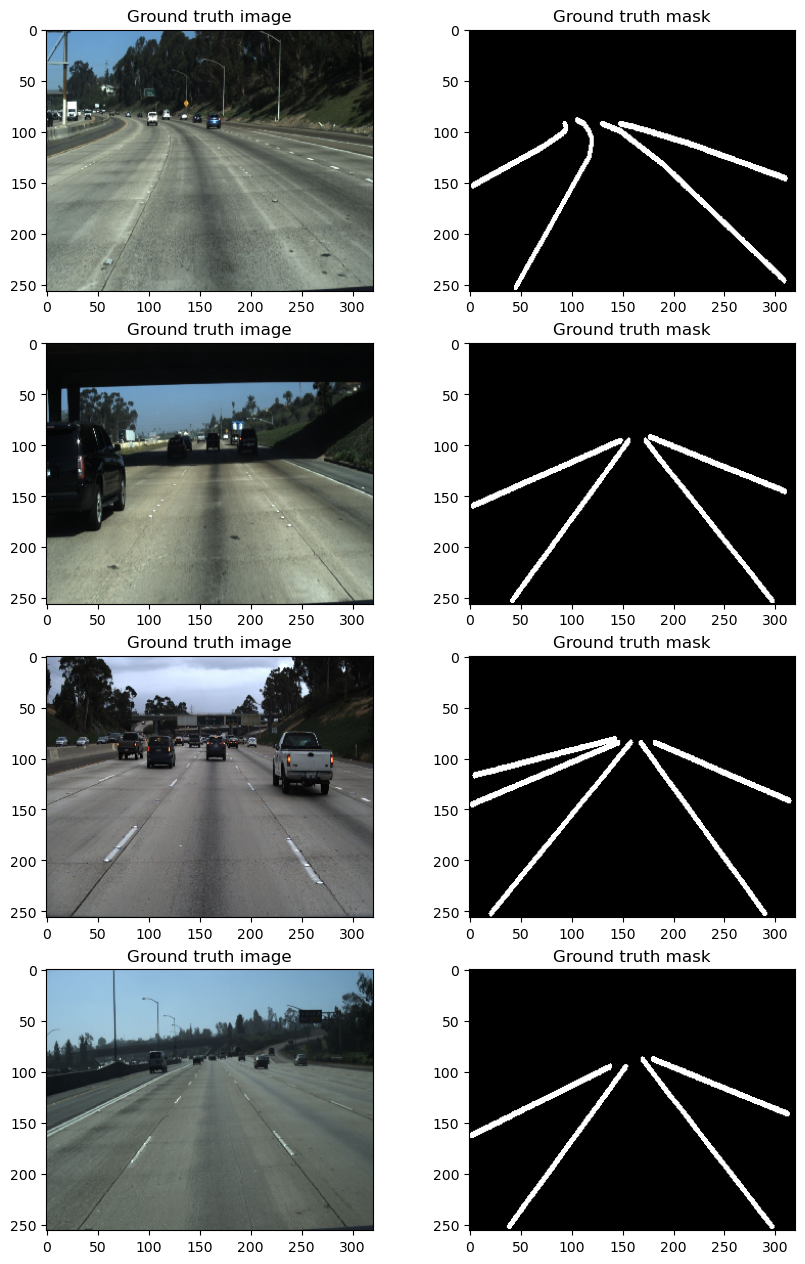

In [12]:
# visualize some samples from the training set
plt.figure(figsize=(10, 40))
s, e = 80, 84
index = 1

for i, j in zip(X_train[s:e], Y_train[s:e]):
    plt.subplot(10, 2, index)
    plt.imshow(i/255.)
    plt.title('Ground truth image')
    
    plt.subplot(10, 2, index+1)
    plt.imshow(j, cmap='gray')
    plt.title('Ground truth mask')
    index += 2

In [13]:
# define the model's architecture

from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, Concatenate
from keras.models import Model

def unet(input_size=(256,320,3)):
    inputs = Input(input_size)
    rescale = keras.layers.Rescaling(1./255)(inputs)
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(rescale)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    # Decoder
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(drop5))
    merge6 = Concatenate(axis=3)([conv4, up6])
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    
    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv6))
    merge7 = Concatenate(axis=3)([conv3, up7])
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    
    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv7))
    merge8 = Concatenate(axis=3)([conv2, up8])
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    
    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv8))
    merge9 = Concatenate(axis=3)([conv1, up9])
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    
    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

model = unet()

In [14]:
# Compile the model
model.compile(optimizer='adam', loss=keras.losses.BinaryFocalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 320, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 320, 64  1792        ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

In [15]:
# train the model
epochs = 32
batch_size = 8

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]

model.fit(
    X_train,
    Y_train,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(X_val, Y_val),
    batch_size=batch_size
)

Epoch 1/32


2023-07-15 07:20:53.455187: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


225/225 [==============================] - 113s 398ms/step - loss: 1.0429 - accuracy: 0.9536 - val_loss: 0.0347 - val_accuracy: 0.9591
Epoch 2/32
225/225 [==============================] - 91s 403ms/step - loss: 0.0256 - accuracy: 0.9655 - val_loss: 0.0189 - val_accuracy: 0.9710
Epoch 3/32
225/225 [==============================] - 88s 392ms/step - loss: 0.0173 - accuracy: 0.9732 - val_loss: 0.0173 - val_accuracy: 0.9737
Epoch 4/32
225/225 [==============================] - 88s 392ms/step - loss: 0.0151 - accuracy: 0.9762 - val_loss: 0.0158 - val_accuracy: 0.9745
Epoch 5/32
225/225 [==============================] - 88s 393ms/step - loss: 0.0138 - accuracy: 0.9779 - val_loss: 0.0141 - val_accuracy: 0.9780
Epoch 6/32
225/225 [==============================] - 91s 403ms/step - loss: 0.0131 - accuracy: 0.9787 - val_loss: 0.0137 - val_accuracy: 0.9784
Epoch 7/32
225/225 [==============================] - 88s 392ms/step - loss: 0.0128 - accuracy: 0.9792 - val_loss: 0.0134 - val_accuracy: 0.

In [16]:
preds = model.predict(X_val)
preds.max(), preds.min()

7/7 [==============================] - 12s 307ms/step


(0.99999416, 0.0)

In [17]:
# make a directory to store some predicted lane masks
!mkdir out

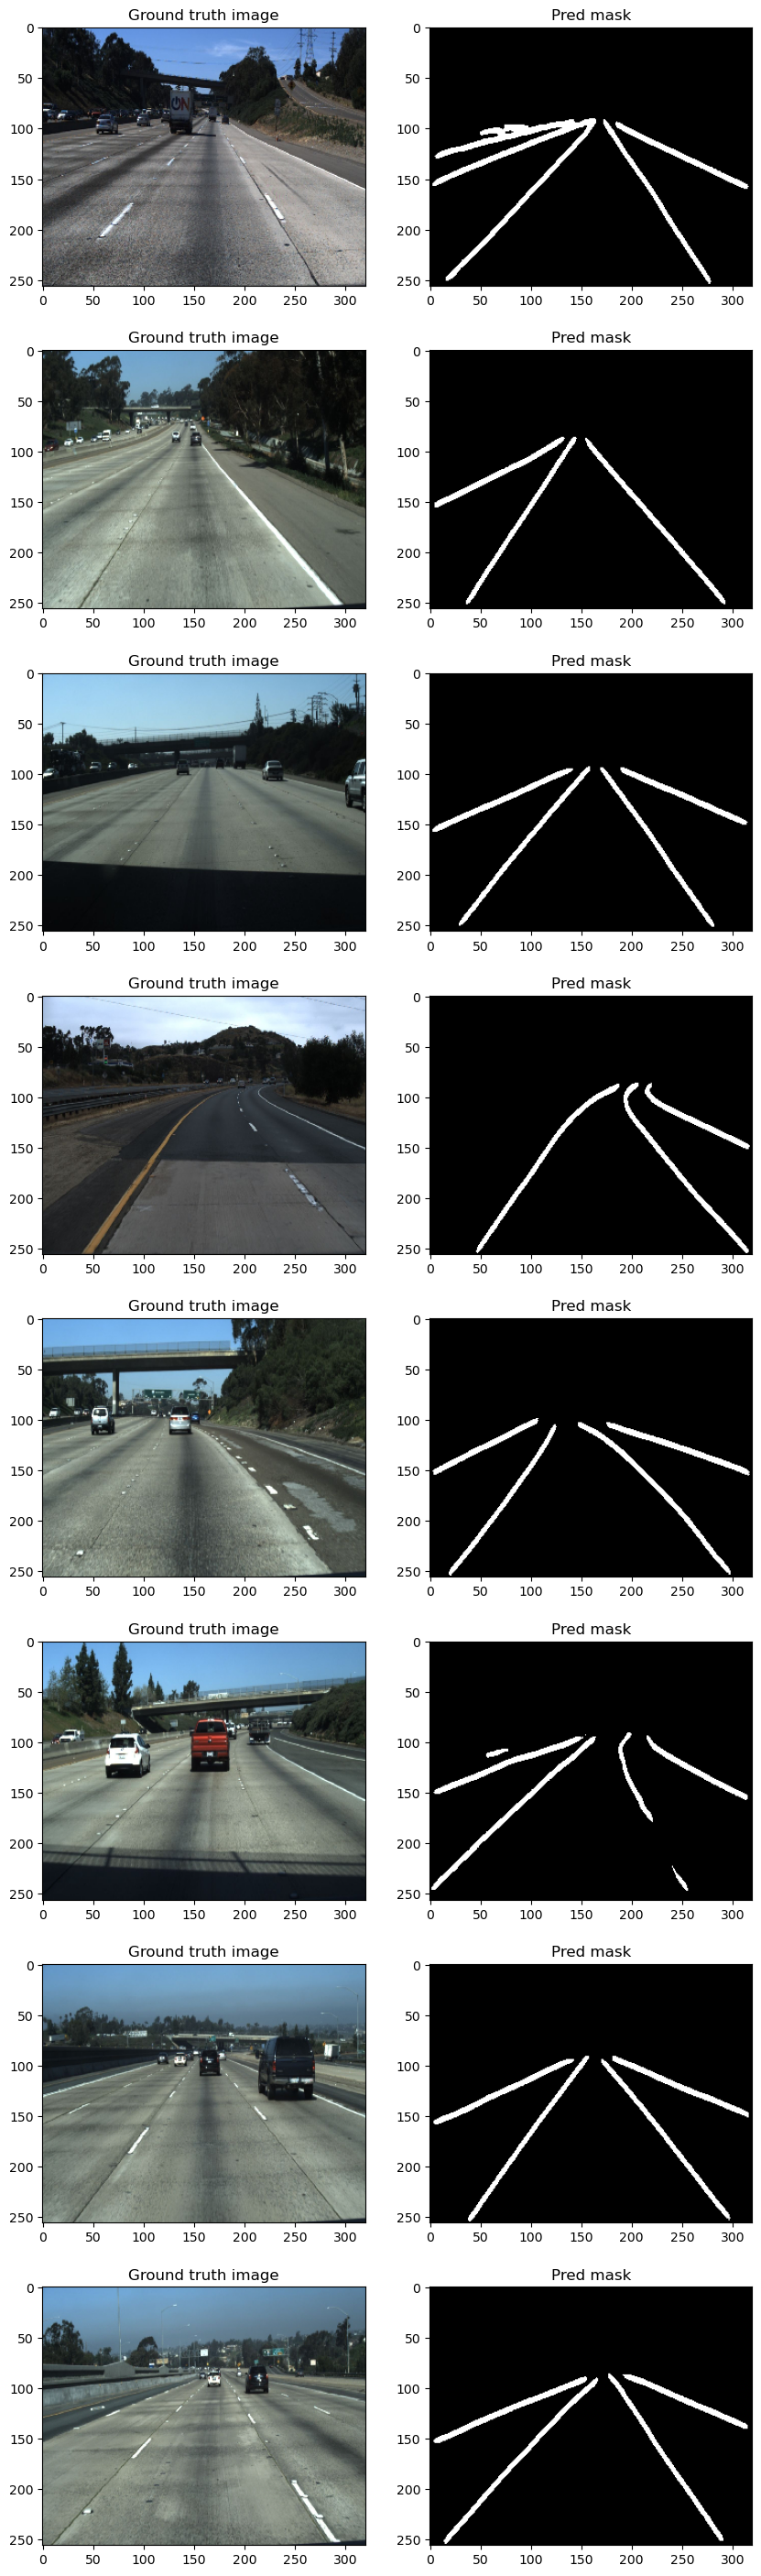

In [18]:
# visualize some results from the validation set.
plt.figure(figsize=(10, 45))
s, e = 90, 98
index = 1

preds = (preds >= .5).astype('int')
for i, j, k in zip(X_val[s:e], preds[s:e], Y_val[s:e]):
    
    # write these images into file as well
    cv2.imwrite(f'./out/img-{index}.jpg', i)
    cv2.imwrite(f'./out/pred-{index}.jpg', j*255.)
    cv2.imwrite(f'./out/ground-{index}.jpg', k*255.)
    
    plt.subplot(10, 2, index)
    plt.imshow(i/255.)
    plt.title('Ground truth image')
    
    plt.subplot(10, 2, index+1)
    plt.imshow(j, cmap='gray')
    plt.title('Pred mask')
    index += 2

In [19]:
# zip 'out' folder
!zip out.zip out -r -q

In [20]:
# save the model
model.save('/lane-detection-model')

In [21]:
# create metrices
accuracy = tf.keras.metrics.Accuracy()
precision = tf.keras.metrics.Precision()
recal = tf.keras.metrics.Recall()
iou = tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1])


# accuracy
accuracy.update_state(Y_val, preds)
accuracy_value = accuracy.result().numpy()
# precision
precision.update_state(Y_val, preds)
precision_value = precision.result().numpy()
# recal
recal.update_state(Y_val, preds)
recal_value = recal.result().numpy()
# f1 score
f1_score = 2 / ((1 / precision_value) + (1 / recal_value))

# Intersection over union (IoU)
iou.update_state(Y_val, preds)
iou_value = iou.result().numpy()

print("Accuracy:", accuracy_value)
print("Precision:", precision_value)
print("Recal:", recal_value)
print('F1 Score: ', f1_score)
print('IoU: ', iou_value)

Accuracy: 0.9790163
Precision: 0.7661074
Recal: 0.7456274
F1 Score:  0.7557286672720368
IoU:  0.60736644


---

The notebook is authored by: [Hikmatullah Mohammadi](https://www.linkedin.com/in/hikmatullah-mohammadi-871550225/)